# TEXT ANALYSIS

The first step before moving on to the text analysis for our dataset is to import all the necessary libraries, create a Spark Session and load the dataset that we prepared from the EDA.

This dataset does not contain any duplicated entries, we checked for null values and tested to see if there were any unrealistic values. The dataset `df` that we are loading here is free of any uncertainties. The only step that we will take as far as editing the dataset will be the removal of outliers in the column **runtimeMinutes**.

In [1]:
!pip install pyspark
!pip install pyarrow

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Create Spark Session
spark = SparkSession.builder.appName("IMDbDataset-Model").getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/data/project/df.zip'
extract_path = '/content/df'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
df = spark.read.parquet('/content/df/*.parquet')
df.show(10)

+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|   nconst|   tconst|        primaryTitle|isAdult|startYear|runtimeMinutes|              genres|averageRating|numVotes|          directors|             writers|       category|         primaryName|   primaryProfession|      knownForTitles|
+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|nm0063413|tt0000941|      Locura de amor|      0|     1909|            45|               Drama|          4.6|      29|nm0063413,nm0550220|nm0063413,nm05502...|       director|    Ricardo de Baños|director,cinemato...|tt0002886,tt00044...|
|nm0063412|tt0001184|Don Juan de Serra..

In [7]:
# Drop movies over 600 minutes
df = df[df["runtimeMinutes"] <= 600]

Now that we loaded the dataset we are ready for Text Analysis as far as the `primaryTitle`, `genres` and `primaryProfession`.

After some investigation we decided to create two different pipelines for text analysis. In both pipelines we will apply tokenization, puncuation, stopwords removal and TF-IDF. However, we chose to apply lemmatization only in the one of them. We are doing this because the dataset without lemmatization performed better when we were working with Regression models. However the lemmatized dataset gave us better results as far as Topic Detection.

At the end of the Text Analysis we will named the two datasets `df_text` and `df_lemm`, which refer to the no lemmatization pipeline and the pipeline with lemmatization, respectivly.

## TEXT ANALYSIS

### A. PIPELINE WITHOUT LEMMATIZATION ON `primaryTitle`.

#### `primaryTitle`
1. Tokenization

In [8]:
from pyspark.ml.feature import Tokenizer

# Create a new column called 'tokens' from 'primaryTitle'
tokenizer = Tokenizer(inputCol="primaryTitle", outputCol="tokens")
df_text = tokenizer.transform(df)

2. Punctuation

In [9]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re

# UDF to clean each word in the list by removing punctuation
def clean_tokens(word_list):
    return [re.sub(r"[^\w\s]", "", word).strip() for word in word_list if re.sub(r"[^\w\s]", "", word).strip()]

clean_udf = udf(clean_tokens, ArrayType(StringType()))

# Apply the UDF to your tokenized column
df_text = df_text.withColumn("clean_tokens", clean_udf("tokens"))

3. Stopwords Removal

At this step we chose to remove some words manual, because we observed that we possibly have other languages in the dataset and our pipeline could not remove them automatically. We know that it is impossible to remove all the possible stopwords manually, but we tried to remove as many of them as possible.

In [10]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="clean_tokens", outputCol="filtered_tokens")
df_text = remover.transform(df_text)

In [11]:
custom_stopwords = [
    "de", "la", "el", "en", "un", "una", "del", "y", "con",
    "da", "las", "le", "o", "na", "dos", "ao", "los", "les", "des",
    "das", "et", "di", "al", "et", "il", "wu", "u", "du", "der", "im",
    "lo", "l'", "d'", "di", "della", "delle", "del", "dei", "lo", "so"
]

def remove_custom(words):
    return [w for w in words if w not in custom_stopwords]
remove_udf = udf(remove_custom, ArrayType(StringType()))
df_text = df_text.withColumn("filtered_tokens", remove_udf("filtered_tokens"))

4. TF-IDF

In [12]:
from pyspark.ml.feature import HashingTF

hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=1000)
df_text = hashing_tf.transform(df_text)

In [13]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_text)
df_text = idf_model.transform(df_text)

`genres`

In [14]:
from pyspark.sql.functions import split

df_text = df_text.withColumn("genre_tokens", split(col("genres"), ","))

In [15]:
from pyspark.sql.functions import array_distinct

df_text = df_text.withColumn("genre_tokens", array_distinct(col("genre_tokens")))

In [16]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="genre_tokens", outputCol="genre_features")
cv_model = cv.fit(df_text)
df_text = cv_model.transform(df_text)

`primaryProfession`

In [17]:
from pyspark.sql.functions import split
from pyspark.sql.functions import array_distinct

df_text = df_text.withColumn("profession_tokens", split(col("primaryProfession"), ","))
df_text = df_text.withColumn("profession_tokens", array_distinct(col("profession_tokens")))

In [18]:
from pyspark.ml.feature import CountVectorizer

cv_prof = CountVectorizer(inputCol="profession_tokens", outputCol="profession_features")
cv_prof_model = cv_prof.fit(df_text)
df_text = cv_prof_model.transform(df_text)

This whole pipeline created many columns that we possibly do not need in the next steps of our analysis. So we are going to remove any irrelevant column to reduce the complexity of our dataset.

In [19]:
df_text = df_text.drop("tokens", "clean_tokens", "raw_features","genre_tokens", "profession_tokens")

At this stage we have the dataset `df_text`, ready for Machine Learning algorithms.

Moving on we will prepare the second dataset that we will use, as mentioned above, for Topic Detection.

### B. PIPELINE WITH LEMMATIZATION ON `primaryTitle`.

`primaryTitle`

In [55]:
# TOKENIZATION
# Create a new column called 'tokens' from 'primaryTitle'
tokenizer = Tokenizer(inputCol="primaryTitle", outputCol="tokens")
df_lemm = tokenizer.transform(df)


# PUNCUATION
# UDF to clean each word in the list by removing punctuation
def clean_tokens(word_list):
    return [re.sub(r"[^\w\s]", "", word).strip() for word in word_list if re.sub(r"[^\w\s]", "", word).strip()]

clean_udf = udf(clean_tokens, ArrayType(StringType()))

# Apply the UDF to your tokenized column
df_lemm = df_lemm.withColumn("clean_tokens", clean_udf("tokens"))


# STOPWORDS REMOVAL
remover = StopWordsRemover(inputCol="clean_tokens", outputCol="filtered_tokens")
df_lemm = remover.transform(df_lemm)

custom_stopwords = [
    "de", "la", "el", "en", "un", "una", "del", "y", "con",
    "da", "las", "le", "o", "na", "dos", "ao", "los", "les", "des",
    "das", "et", "di", "al", "et", "il", "wu", "u", "du", "der", "im",
    "lo", "l'", "d'", "di", "della", "delle", "del", "dei", "lo", "so"
]

def remove_custom(words):
    return [w for w in words if w not in custom_stopwords]
remove_udf = udf(remove_custom, ArrayType(StringType()))
df_lemm = df_lemm.withColumn("filtered_tokens", remove_udf("filtered_tokens"))


# LEMMATIZATION
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(word_list):
    return [lemmatizer.lemmatize(w) for w in word_list]

lemmatize_udf = udf(lemmatize_tokens, ArrayType(StringType()))
df_lemm = df_lemm.withColumn("lemmatized_tokens", lemmatize_udf("filtered_tokens"))


# TF-IDF
hashing_tf = HashingTF(inputCol="lemmatized_tokens", outputCol="raw_features", numFeatures=1000)
df_lemm = hashing_tf.transform(df_lemm)

idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_lemm)
df_lemm = idf_model.transform(df_lemm)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


`genres`

In [56]:
df_lemm = df_lemm.withColumn("genre_tokens", split(col("genres"), ","))
df_lemm = df_lemm.withColumn("genre_tokens", array_distinct(col("genre_tokens")))

cv = CountVectorizer(inputCol="genre_tokens", outputCol="genre_features")
cv_model = cv.fit(df_lemm)
df_lemm = cv_model.transform(df_lemm)

`primaryProfession`

In [57]:
df_lemm = df_lemm.withColumn("profession_tokens", split(col("primaryProfession"), ","))
df_lemm = df_lemm.withColumn("profession_tokens", array_distinct(col("profession_tokens")))

cv_prof = CountVectorizer(inputCol="profession_tokens", outputCol="profession_features")
cv_prof_model = cv_prof.fit(df_lemm)
df_lemm = cv_prof_model.transform(df_lemm)

And again here, we are going to remove any irrelevant columns.

In [58]:
df_lemm = df_lemm.drop("tokens", "clean_tokens", "raw_features","genre_tokens", "profession_tokens")

So now we are ready to move on with our models and the topic detection.

## MACHINE LEARNING - REGRESSION ALGORITHMS

We tried many different models, in order to achieve the highest possible result. However the models did not seem to perform very well, so we tried to predict, using the same models again, on the sentiment score instead of average rating.

### **A. PREDICTIONS ON `averageRating`**

We began by splitting the dataset into train(80%) and test(20%). Then by filtering and transforming variables like `genres`, `startYear`, and `isAdult`, and narrowing down the pool of directors and writers, we removed noise and reduced redundancy. This made our similarity comparisons more meaningful and accurate. Without this preprocessing, the model might have been biased or misled by irrelevant or overly common metadata, leading to less relevant recommendations.

In [20]:
# Split dataset into train and test set
train, test = df_text.randomSplit([0.8, 0.2], seed=42)

In [21]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

num_cols = ["runtimeMinutes", "startYear", "numVotes"]
assembler_num = VectorAssembler(inputCols=num_cols, outputCol="numericVector")
train = assembler_num.transform(train)
test = assembler_num.transform(test)

scaler = StandardScaler(inputCol="numericVector", outputCol="scaledNumeric", withMean=True, withStd=True)
scaler_model = scaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

assembler = VectorAssembler(
    inputCols=["scaledNumeric", "genre_features", "tfidf_features", "profession_features"],
    outputCol="features"
)
train = assembler.transform(train)
test = assembler.transform(test)

In [22]:
# Evaluation setup
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol="averageRating", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="averageRating", predictionCol="prediction", metricName="r2")

**LINEAR REGRESSION**

In [27]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="averageRating")
lr_model = lr.fit(train)
lr_preds = lr_model.transform(test)

rmse = evaluator_rmse.evaluate(lr_preds)
r2 = evaluator_r2.evaluate(lr_preds)

print(f"Linear Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Linear Regression — RMSE: 1.1795, R²: 0.2140


**RIDGE REGRESSION**

For Ridge Regression we tried different hyperparameters in order to get more accurate predictions.

In [28]:
ridge = LinearRegression(featuresCol="features", labelCol="averageRating", regParam=1.0, elasticNetParam=0.0)
ridge_model = ridge.fit(train)
ridge_preds = ridge_model.transform(test)

rmse = evaluator_rmse.evaluate(ridge_preds)
r2 = evaluator_r2.evaluate(ridge_preds)

print(f"Ridge Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Ridge Regression — RMSE: 1.2040, R²: 0.1809


In [29]:
ridge = LinearRegression(featuresCol="features", labelCol="averageRating", regParam=0.1, elasticNetParam=0.0)
ridge_model = ridge.fit(train)
ridge_preds = ridge_model.transform(test)

rmse = evaluator_rmse.evaluate(ridge_preds)
r2 = evaluator_r2.evaluate(ridge_preds)

print(f"Ridge Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Ridge Regression — RMSE: 1.1802, R²: 0.2130


In [30]:
ridge = LinearRegression(featuresCol="features", labelCol="averageRating", regParam=0.01, elasticNetParam=0.0)
ridge_model = ridge.fit(train)
ridge_preds = ridge_model.transform(test)

rmse = evaluator_rmse.evaluate(ridge_preds)
r2 = evaluator_r2.evaluate(ridge_preds)

print(f"Ridge Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Ridge Regression — RMSE: 1.1794, R²: 0.2140


In [31]:
ridge = LinearRegression(featuresCol="features", labelCol="averageRating", regParam=0.001, elasticNetParam=0.0)
ridge_model = ridge.fit(train)
ridge_preds = ridge_model.transform(test)

rmse = evaluator_rmse.evaluate(ridge_preds)
r2 = evaluator_r2.evaluate(ridge_preds)

print(f"Ridge Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Ridge Regression — RMSE: 1.1795, R²: 0.2140


**LASSO REGRESSION**

In [32]:
lasso = LinearRegression(featuresCol="features", labelCol="averageRating", regParam=0.01, elasticNetParam=1.0)
lasso_model = lasso.fit(train)
lasso_preds = lasso_model.transform(test)

rmse = evaluator_rmse.evaluate(lasso_preds)
r2 = evaluator_r2.evaluate(lasso_preds)

print(f"Lasso Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Lasso Regression — RMSE: 1.1812, R²: 0.2117


In [33]:
lasso = LinearRegression(featuresCol="features", labelCol="averageRating", regParam=0.1, elasticNetParam=1.0)
lasso_model = lasso.fit(train)
lasso_preds = lasso_model.transform(test)

rmse = evaluator_rmse.evaluate(lasso_preds)
r2 = evaluator_r2.evaluate(lasso_preds)

print(f"Lasso Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Lasso Regression — RMSE: 1.2157, R²: 0.1649


**ELASTIC NET**

In [34]:
elastic = LinearRegression(featuresCol="features", labelCol="averageRating", regParam=0.01, elasticNetParam=0.5)
elastic_model = elastic.fit(train)
elastic_preds = elastic_model.transform(test)

rmse = evaluator_rmse.evaluate(elastic_preds)
r2 = evaluator_r2.evaluate(elastic_preds)

print(f"Elastic Net — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Elastic Net — RMSE: 1.1789, R²: 0.2146


In [35]:
elastic = LinearRegression(featuresCol="features", labelCol="averageRating", regParam=0.01, elasticNetParam=0.3)
elastic_model = elastic.fit(train)
elastic_preds = elastic_model.transform(test)

rmse = evaluator_rmse.evaluate(elastic_preds)
r2 = evaluator_r2.evaluate(elastic_preds)

print(f"Elastic Net — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Elastic Net — RMSE: 1.1781, R²: 0.2157


In [36]:
elastic = LinearRegression(featuresCol="features", labelCol="averageRating", regParam=0.1, elasticNetParam=0.5)
elastic_model = elastic.fit(train)
elastic_preds = elastic_model.transform(test)

rmse = evaluator_rmse.evaluate(elastic_preds)
r2 = evaluator_r2.evaluate(elastic_preds)

print(f"Elastic Net — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Elastic Net — RMSE: 1.1956, R²: 0.1923


**RANDOM FOREST**

In [37]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="averageRating", numTrees=100, seed=42)
rf_model = rf.fit(train)
rf_preds = rf_model.transform(test)

rmse = evaluator_rmse.evaluate(rf_preds)
r2 = evaluator_r2.evaluate(rf_preds)

print(f"Random Forest — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Random Forest — RMSE: 1.1642, R²: 0.2341


Only for Random Forest, we tried to collect the important features and rerun the model to see if there is an improvement in the results. So we applied Feature Selection, which removes features with low variance.

In [38]:
importances = rf_model.featureImportances

import numpy as np

# Convert to array
importance_array = importances.toArray()

# Choose a threshold or top N
threshold = 0.001
important_indices = np.where(importance_array > threshold)[0]

print(f"Selected {len(important_indices)} features out of {len(importance_array)}")

Selected 14 features out of 1076


In [39]:
from pyspark.ml.feature import VectorSlicer

slicer = VectorSlicer(inputCol="features", outputCol="selectedFeatures", indices=important_indices.tolist())

# Apply to train/test
train_data_sliced = slicer.transform(train)
test_data_sliced = slicer.transform(test)

In [40]:
rf = RandomForestRegressor(featuresCol="selectedFeatures", labelCol="averageRating", numTrees=100, seed=42)
rf_model_sliced = rf.fit(train_data_sliced)
preds_sliced = rf_model_sliced.transform(test_data_sliced)

rmse = evaluator_rmse.evaluate(preds_sliced)
r2 = evaluator_r2.evaluate(preds_sliced)

print(f"Random Forest (filtered features) — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Random Forest (filtered features) — RMSE: 1.1621, R²: 0.2370


In [41]:
rf_sel = RandomForestRegressor(featuresCol="selectedFeatures", labelCol="averageRating",numTrees=150, maxDepth=10, seed=42)
rf_model_selected = rf_sel.fit(train_data_sliced)
rf_preds_sel = rf_model_selected.transform(test_data_sliced)

rmse_sel = evaluator_rmse.evaluate(rf_preds_sel)
r2_sel = evaluator_r2.evaluate(rf_preds_sel)

print(f"Random Forest — RMSE: {rmse_sel:.4f}, R²: {r2_sel:.4f}")

Random Forest — RMSE: 1.1091, R²: 0.3049


In [42]:
rf_sel = RandomForestRegressor(featuresCol="selectedFeatures", labelCol="averageRating",numTrees=200, maxDepth=10, seed=42)
rf_model_selected = rf_sel.fit(train_data_sliced)
rf_preds_sel = rf_model_selected.transform(test_data_sliced)

rmse_sel = evaluator_rmse.evaluate(rf_preds_sel)
r2_sel = evaluator_r2.evaluate(rf_preds_sel)

print(f"Random Forest — RMSE: {rmse_sel:.4f}, R²: {r2_sel:.4f}")

Random Forest — RMSE: 1.1090, R²: 0.3051


**GRADIENT BOOST TREES**

In [43]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Model Definition
gbt = GBTRegressor(featuresCol="features", labelCol="averageRating", maxIter=50)

# Step 2: Fit the model
gbt_model = gbt.fit(train)

# Step 3: Predictions on test set
gbt_predictions = gbt_model.transform(test)

# Step 4: Evaluation
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

print(f"GBT - Root Mean Squared Error (RMSE): {gbt_rmse:.4f}")
print(f"GBT - R-squared (R²): {gbt_r2:.4f}")

GBT - Root Mean Squared Error (RMSE): 1.1002
GBT - R-squared (R²): 0.3160


In [23]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Model Definition
gbt = GBTRegressor(featuresCol="features", labelCol="averageRating", maxIter=100)

# Step 2: Fit the model
gbt_model = gbt.fit(train)

# Step 3: Predictions on test set
gbt_predictions = gbt_model.transform(test)

# Step 4: Evaluation
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

print(f"GBT - Root Mean Squared Error (RMSE): {gbt_rmse:.4f}")
print(f"GBT - R-squared (R²): {gbt_r2:.4f}")

GBT - Root Mean Squared Error (RMSE): 1.0960
GBT - R-squared (R²): 0.3212


We are going to perform Feature Importance on the GBT model with maxIter equal to 100.

In [24]:
# After fitting GBT:
gbt_importances = gbt_model.featureImportances.toArray()
important_indices_gbt = np.where(gbt_importances > 0.001)[0]

print(f"Selected {len(important_indices_gbt)} features for GBT.")

Selected 33 features for GBT.


In [25]:
from pyspark.ml.feature import VectorSlicer

# Slice and retrain
slicer = VectorSlicer(inputCol="features", outputCol="selectedFeatures", indices=important_indices_gbt.tolist())
train_sliced = slicer.transform(train)
test_sliced = slicer.transform(test)

After getting the important features we are going to evaluate the performance of the GBT model with maxIter equal to 100, 150, 200 and 200 with maxDepth 10.

In [26]:
gbt = GBTRegressor(featuresCol="selectedFeatures", labelCol="averageRating", maxIter=100)
gbt_model = gbt.fit(train_sliced)
gbt_preds = gbt_model.transform(test_sliced)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
gbt_r2 = evaluator_r2.evaluate(gbt_preds)

print(f"GBT (filtered features) — RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")

GBT (filtered features) — RMSE: 1.0876, R²: 0.3316


In [27]:
gbt = GBTRegressor(featuresCol="selectedFeatures", labelCol="averageRating", maxIter=150)
gbt_model = gbt.fit(train_sliced)
gbt_preds = gbt_model.transform(test_sliced)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
gbt_r2 = evaluator_r2.evaluate(gbt_preds)

print(f"GBT (filtered features) — RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")

GBT (filtered features) — RMSE: 1.0844, R²: 0.3356


In [26]:
gbt = GBTRegressor(featuresCol="selectedFeatures", labelCol="averageRating", maxIter=200)
gbt_model = gbt.fit(train_sliced)
gbt_preds = gbt_model.transform(test_sliced)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
gbt_r2 = evaluator_r2.evaluate(gbt_preds)

print(f"GBT (filtered features) — RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")

GBT (filtered features) — RMSE: 1.0812, R²: 0.3394


In [29]:
gbt = GBTRegressor(featuresCol="selectedFeatures", labelCol="averageRating", maxIter=200, maxDepth=7)
gbt_model = gbt.fit(train_sliced)
gbt_preds = gbt_model.transform(test_sliced)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
gbt_r2 = evaluator_r2.evaluate(gbt_preds)

print(f"GBT (filtered features) — RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")

GBT (filtered features) — RMSE: 1.0855, R²: 0.3342


### **B. PREDICTIONS ON `sentiment`**

We used **TextBlob** to extract sentiment scores from the `primaryTitle` of each movie. This gave us an additional numeric feature — the sentiment polarity — that could be useful for predicting movie ratings. Since `primaryTitle` often contains emotionally charged or descriptive language, sentiment analysis adds a layer of semantic understanding that purely structural features (like year or runtime) can't capture.

In [30]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity if text else 0.0

sentiment_udf = udf(get_sentiment, FloatType())

# Apply sentiment scoring to a text column (e.g. primaryTitle)
df_text = df_text.withColumn("sentiment", sentiment_udf("primaryTitle"))

In [31]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Step 1: Split the data
train_data, test_data = df_text.randomSplit([0.8, 0.2], seed=42)

# Step 2: Assemble numeric features (on both sets)
assembler_num = VectorAssembler(inputCols=["runtimeMinutes", "startYear", "numVotes"], outputCol="numericVector")
train_data = assembler_num.transform(train_data)
test_data = assembler_num.transform(test_data)

# Step 3: Standardize using training set only
scaler = StandardScaler(inputCol="numericVector", outputCol="scaledNumeric", withMean=True, withStd=True)
scaler_model = scaler.fit(train_data)

train_data = scaler_model.transform(train_data)
test_data = scaler_model.transform(test_data)

# Step 4: Continue with final assembler
assembler = VectorAssembler(
    inputCols=["scaledNumeric", "genre_features", "tfidf_features", "profession_features"],
    outputCol="features"
)
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

We then used all the same models as above, for the sentiment score.

**LINEAR REGRESSION**

In [32]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="sentiment")
model = lr.fit(train_data)

from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Root Mean Squared Error (RMSE): 0.1356
R-squared (R²): 0.3347


**RIDGE REGRESSION**

In [33]:
ridge = LinearRegression(featuresCol="features", labelCol="sentiment", regParam=1.0, elasticNetParam=0.0)
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

rmse = evaluator_rmse.evaluate(ridge_predictions)
r2 = evaluator_r2.evaluate(ridge_predictions)

print(f"Ridge Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Ridge Regression — RMSE: 0.1583, R²: 0.0940


In [34]:
ridge = LinearRegression(featuresCol="features", labelCol="sentiment", regParam=0.1, elasticNetParam=0.0)
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

rmse = evaluator_rmse.evaluate(ridge_predictions)
r2 = evaluator_r2.evaluate(ridge_predictions)

print(f"Ridge Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Ridge Regression — RMSE: 0.1399, R²: 0.2925


In [35]:
ridge = LinearRegression(featuresCol="features", labelCol="sentiment", regParam=0.01, elasticNetParam=0.0)
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

rmse = evaluator_rmse.evaluate(ridge_predictions)
r2 = evaluator_r2.evaluate(ridge_predictions)

print(f"Ridge Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Ridge Regression — RMSE: 0.1356, R²: 0.3345


In [36]:
ridge = LinearRegression(featuresCol="features", labelCol="sentiment", regParam=0.001, elasticNetParam=0.0)
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

rmse = evaluator_rmse.evaluate(ridge_predictions)
r2 = evaluator_r2.evaluate(ridge_predictions)

print(f"Ridge Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Ridge Regression — RMSE: 0.1356, R²: 0.3348


**LASSO REGRESSION**

In [37]:
lasso = LinearRegression(featuresCol="features", labelCol="sentiment", regParam=0.01, elasticNetParam=1.0)
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)

rmse = evaluator_rmse.evaluate(lasso_predictions)
r2 = evaluator_r2.evaluate(lasso_predictions)

print(f"Lasso Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Lasso Regression — RMSE: 0.1493, R²: 0.1935


In [38]:
lasso = LinearRegression(featuresCol="features", labelCol="sentiment", regParam=0.1, elasticNetParam=1.0)
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)

rmse = evaluator_rmse.evaluate(lasso_predictions)
r2 = evaluator_r2.evaluate(lasso_predictions)

print(f"Lasso Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Lasso Regression — RMSE: 0.1663, R²: -0.0000


**ELASTIC NET**

In [39]:
elastic = LinearRegression(featuresCol="features", labelCol="sentiment", regParam=0.01, elasticNetParam=0.5)
elastic_model = elastic.fit(train_data)
elastic_predictions = elastic_model.transform(test_data)

rmse = evaluator_rmse.evaluate(elastic_predictions)
r2 = evaluator_r2.evaluate(elastic_predictions)

print(f"Elastic Net Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Elastic Net Regression — RMSE: 0.1428, R²: 0.2628


In [40]:
elastic = LinearRegression(featuresCol="features", labelCol="sentiment", regParam=0.01, elasticNetParam=0.3)
elastic_model = elastic.fit(train_data)
elastic_predictions = elastic_model.transform(test_data)

rmse = evaluator_rmse.evaluate(elastic_predictions)
r2 = evaluator_r2.evaluate(elastic_predictions)

print(f"Elastic Net Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Elastic Net Regression — RMSE: 0.1395, R²: 0.2960


In [41]:
elastic = LinearRegression(featuresCol="features", labelCol="sentiment", regParam=0.1, elasticNetParam=0.5)
elastic_model = elastic.fit(train_data)
elastic_predictions = elastic_model.transform(test_data)

rmse = evaluator_rmse.evaluate(elastic_predictions)
r2 = evaluator_r2.evaluate(elastic_predictions)

print(f"Elastic Net Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Elastic Net Regression — RMSE: 0.1659, R²: 0.0048


**RANDOM FOREST**

In [42]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="sentiment", numTrees=100, seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rmse_rf = evaluator_rmse.evaluate(rf_predictions)
r2_rf = evaluator_r2.evaluate(rf_predictions)

print(f"Random Forest Regression — RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

Random Forest Regression — RMSE: 0.1486, R²: 0.2008


Again we are going to perform Feature Importance.

In [43]:
importances = rf_model.featureImportances

import numpy as np

# Convert to array
importance_array = importances.toArray()

# Choose a threshold or top N
threshold = 0.001
important_indices = np.where(importance_array > threshold)[0]

print(f"Selected {len(important_indices)} features out of {len(importance_array)}")

from pyspark.ml.feature import VectorSlicer

slicer = VectorSlicer(inputCol="features", outputCol="selectedFeatures", indices=important_indices.tolist())

# Apply to train/test
train_data_sliced = slicer.transform(train_data)
test_data_sliced = slicer.transform(test_data)

Selected 21 features out of 1076


In [44]:
rf = RandomForestRegressor(featuresCol="selectedFeatures", labelCol="sentiment", numTrees=100, seed=42)
rf_model_sliced = rf.fit(train_data_sliced)
preds_sliced = rf_model_sliced.transform(test_data_sliced)

rmse = evaluator_rmse.evaluate(preds_sliced)
r2 = evaluator_r2.evaluate(preds_sliced)

print(f"Random Forest (filtered features) — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Random Forest (filtered features) — RMSE: 0.1486, R²: 0.2017


In [45]:
rf_sel = RandomForestRegressor(featuresCol="selectedFeatures", labelCol="sentiment",numTrees=150, maxDepth=10, seed=42)
rf_model_selected = rf_sel.fit(train_data_sliced)
rf_preds_sel = rf_model_selected.transform(test_data_sliced)

rmse_sel = evaluator_rmse.evaluate(rf_preds_sel)
r2_sel = evaluator_r2.evaluate(rf_preds_sel)

print(f"Random Forest — RMSE: {rmse_sel:.4f}, R²: {r2_sel:.4f}")

Random Forest — RMSE: 0.1440, R²: 0.2500


In [46]:
rf_sel = RandomForestRegressor(featuresCol="selectedFeatures", labelCol="sentiment",numTrees=200, maxDepth=10, seed=42)
rf_model_selected = rf_sel.fit(train_data_sliced)
rf_preds_sel = rf_model_selected.transform(test_data_sliced)

rmse_sel = evaluator_rmse.evaluate(rf_preds_sel)
r2_sel = evaluator_r2.evaluate(rf_preds_sel)

print(f"Random Forest — RMSE: {rmse_sel:.4f}, R²: {r2_sel:.4f}")

Random Forest — RMSE: 0.1441, R²: 0.2491


**GRADIENT BOOST TREES**

In [47]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Model Definition
gbt = GBTRegressor(featuresCol="features", labelCol="sentiment", maxIter=50)

# Step 2: Fit the model
gbt_model = gbt.fit(train_data)

# Step 3: Predictions on test set
gbt_predictions = gbt_model.transform(test_data)

# Step 4: Evaluation
evaluator_rmse = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="r2")

gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

print(f"GBT - Root Mean Squared Error (RMSE): {gbt_rmse:.4f}")
print(f"GBT - R-squared (R²): {gbt_r2:.4f}")

GBT - Root Mean Squared Error (RMSE): 0.1347
GBT - R-squared (R²): 0.3432


In [48]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Model Definition
gbt = GBTRegressor(featuresCol="features", labelCol="sentiment", maxIter=100)

# Step 2: Fit the model
gbt_model = gbt.fit(train_data)

# Step 3: Predictions on test set
gbt_predictions = gbt_model.transform(test_data)

# Step 4: Evaluation
evaluator_rmse = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="r2")

gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

print(f"GBT - Root Mean Squared Error (RMSE): {gbt_rmse:.4f}")
print(f"GBT - R-squared (R²): {gbt_r2:.4f}")

GBT - Root Mean Squared Error (RMSE): 0.1318
GBT - R-squared (R²): 0.3714


Here we are going to get the important features and then run the models again.

In [49]:
# After fitting GBT:
gbt_importances = gbt_model.featureImportances.toArray()
important_indices_gbt = np.where(gbt_importances > 0.001)[0]

print(f"Selected {len(important_indices_gbt)} features for GBT.")

Selected 128 features for GBT.


In [50]:
from pyspark.ml.feature import VectorSlicer

# Slice and retrain
slicer = VectorSlicer(inputCol="features", outputCol="selectedFeatures", indices=important_indices_gbt.tolist())
train_data_sliced = slicer.transform(train_data)
test_data_sliced = slicer.transform(test_data)

In [51]:
gbt = GBTRegressor(featuresCol="selectedFeatures", labelCol="sentiment", maxIter=100)
gbt_model = gbt.fit(train_data_sliced)
gbt_preds = gbt_model.transform(test_data_sliced)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
gbt_r2 = evaluator_r2.evaluate(gbt_preds)

print(f"GBT (filtered features) — RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")

GBT (filtered features) — RMSE: 0.1323, R²: 0.3669


In [52]:
gbt = GBTRegressor(featuresCol="selectedFeatures", labelCol="sentiment", maxIter=150)
gbt_model = gbt.fit(train_data_sliced)
gbt_preds = gbt_model.transform(test_data_sliced)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
gbt_r2 = evaluator_r2.evaluate(gbt_preds)

print(f"GBT (filtered features) — RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")

GBT (filtered features) — RMSE: 0.1315, R²: 0.3744


In [53]:
gbt = GBTRegressor(featuresCol="selectedFeatures", labelCol="sentiment", maxIter=200)
gbt_model = gbt.fit(train_data_sliced)
gbt_preds = gbt_model.transform(test_data_sliced)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
gbt_r2 = evaluator_r2.evaluate(gbt_preds)

print(f"GBT (filtered features) — RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")

GBT (filtered features) — RMSE: 0.1311, R²: 0.3780


In [54]:
gbt = GBTRegressor(featuresCol="selectedFeatures", labelCol="sentiment", maxIter=200, maxDepth=7)
gbt_model = gbt.fit(train_data_sliced)
gbt_preds = gbt_model.transform(test_data_sliced)

gbt_rmse = evaluator_rmse.evaluate(gbt_preds)
gbt_r2 = evaluator_r2.evaluate(gbt_preds)

print(f"GBT (filtered features) — RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")

GBT (filtered features) — RMSE: 0.1319, R²: 0.3709


*COMMENTS ON THE MODELS' PERFORMANCE:*  
The best-performing model was the Gradient Boosted Trees (GBT), which achieved an R² of 0.378 and an RMSE of 0.1305. This indicates that the model explained nearly 38% of the variance in the target variable, showing strong predictive capability relative to the others. The Random Forest model also performed well, with a slightly higher RMSE and lower R², making it a solid runner-up but still inferior to GBT. Linear Regression and Decision Tree models had noticeably weaker performance, with much lower R² values and higher errors. These results confirm that GBT, as an advanced ensemble method, is more effective at capturing complex patterns in the data compared to simpler or less optimized models.

## TOPIC DETECTION

Topic detection is an unsupervised method for discovering the main themes or topics present in a collection of documents or texts (e.g. movie descriptions, reviews, titles). This can help group similar content and understand dominant themes without manual labeling.

**K-MEANS**

In [59]:
from pyspark.ml.clustering import KMeans

# Set number of clusters (topics)
kmeans = KMeans(featuresCol="tfidf_features", predictionCol="cluster", k=7, seed=42)
kmeans_model = kmeans.fit(df_lemm)

df_kmeans = kmeans_model.transform(df_lemm)

In [60]:
# Calculate average rating per cluster
from pyspark.sql.functions import avg

df_kmeans.groupBy("cluster").agg(avg("averageRating").alias("avg_rating")).orderBy("cluster").show()

+-------+------------------+
|cluster|        avg_rating|
+-------+------------------+
|      0| 6.083595330115864|
|      1| 6.329297820823245|
|      2| 6.117675050985722|
|      3|6.1128354725787615|
|      4| 6.075324675324675|
|      5| 5.992667597765362|
|      6| 6.189692982456138|
+-------+------------------+



In [61]:
# Prepare for visualization
# Convert to Pandas for simple cluster summaries
cluster_data = df_kmeans.select("cluster", "lemmatized_tokens").toPandas()

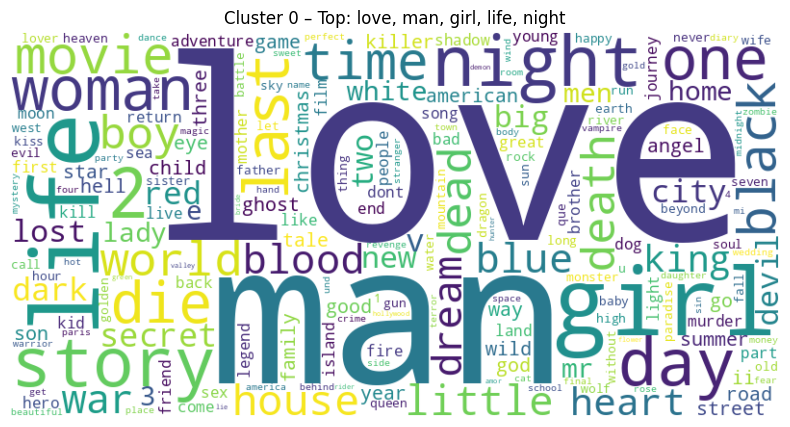

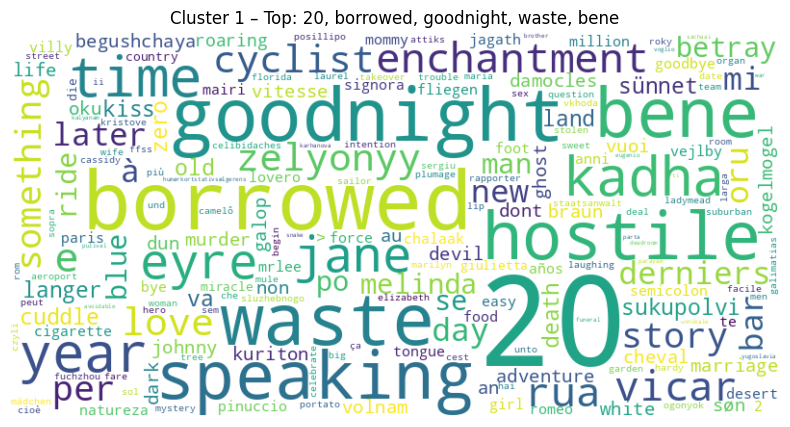

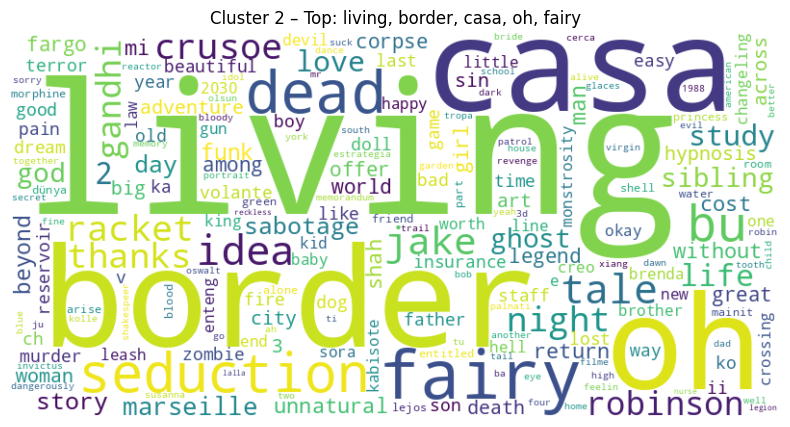

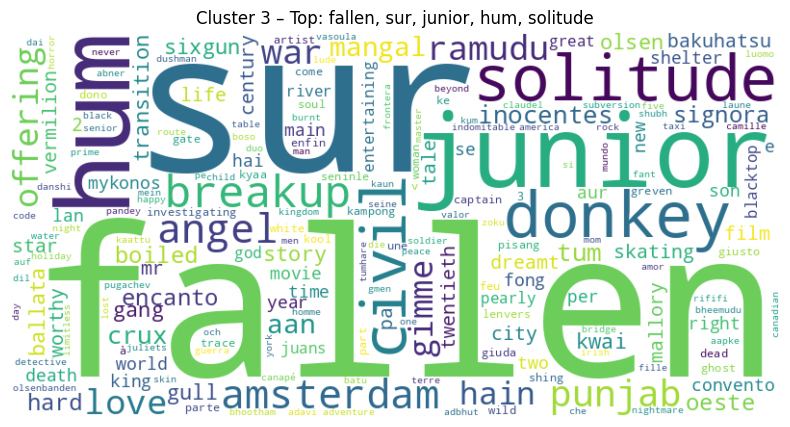

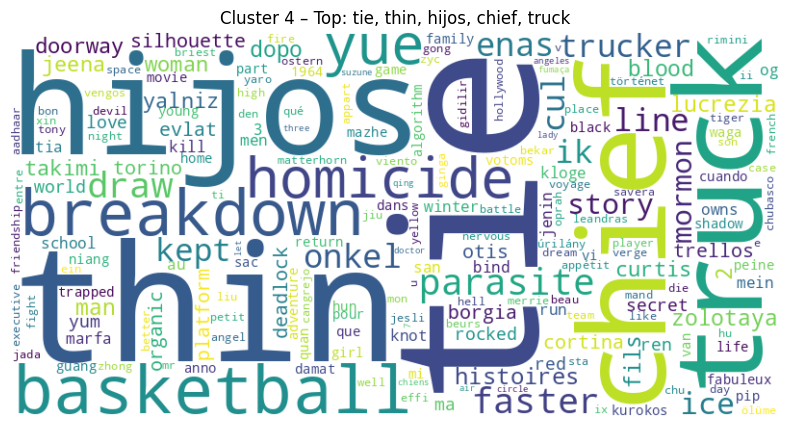

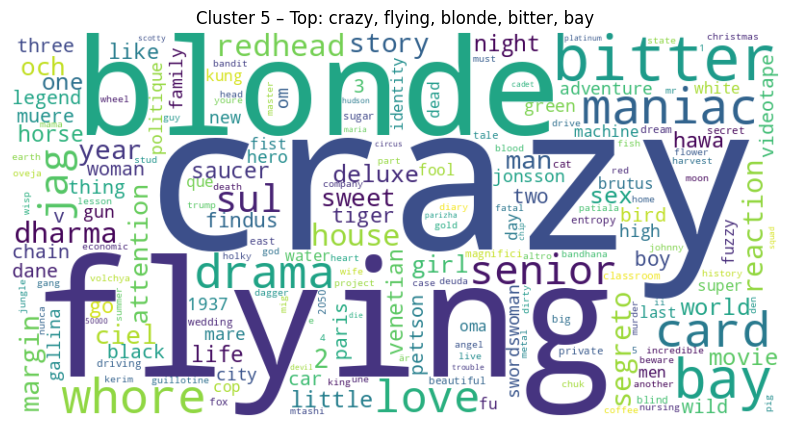

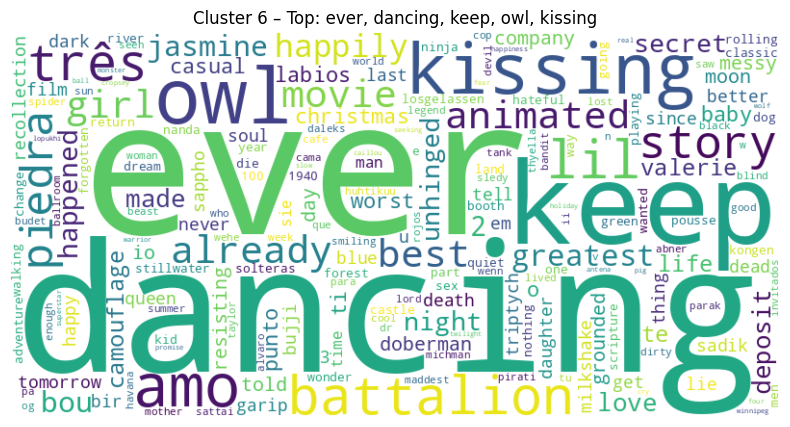

In [62]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Loop through each cluster and create a word cloud
for cluster_id in sorted(cluster_data["cluster"].unique()):
    tokens = cluster_data[cluster_data["cluster"] == cluster_id]["lemmatized_tokens"].explode()
    freq = Counter(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    top_words = ", ".join([word for word, _ in freq.most_common(5)])
    plt.title(f"Cluster {cluster_id} – Top: {top_words}")
    plt.show()

In [63]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="tfidf_features", predictionCol="cluster", metricName="silhouette")
score = evaluator.evaluate(df_kmeans)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0919


In [64]:
silhouette_scores = []

for k in range(2, 9):
    kmeans = KMeans(featuresCol="tfidf_features", predictionCol="cluster", k=k, seed=42)
    model = kmeans.fit(df_lemm)
    transformed = model.transform(df_lemm)

    evaluator = ClusteringEvaluator(featuresCol="tfidf_features", predictionCol="cluster", metricName="silhouette")
    score = evaluator.evaluate(transformed)
    silhouette_scores.append((k, score))

for k, score in silhouette_scores:
    print(f"k={k}, silhouette score={score:.4f}")

k=2, silhouette score=0.0677
k=3, silhouette score=0.0684
k=4, silhouette score=0.0853
k=5, silhouette score=0.0854
k=6, silhouette score=0.0911
k=7, silhouette score=0.0919
k=8, silhouette score=0.0542


Although the silhouette scores across different cluster values are relatively low (with the highest around 0.0919 for k = 7), this is not unusual or problematic when clustering short text such as movie titles. Movie titles are typically very brief—often just a few words—and frequently share common vocabulary (e.g., “man,” “love,” “story”), which limits the separation between clusters in vector space. Despite the low score, meaningful semantic groupings can still emerge, as observed through word clouds and representative titles. Therefore, even a modest silhouette score can reflect useful structure when working with sparse, high-dimensional text data like this.

We also tried using bigrams as a method for topic detection. They capture context and meaning better than individual words. For example, "mr hyde" or "love story" carry more semantic value than "mr" or "hyde" alone. Bigrams can improve feature richness, might increase silhouette scores by giving more unique signals and definitely improve interpretability (especially in word clouds).

In [65]:
from pyspark.ml.feature import NGram
from pyspark.sql.functions import concat

# Create bigrams
bigram = NGram(n=2, inputCol="lemmatized_tokens", outputCol="bigrams")
df_bigrams = bigram.transform(df_lemm)

# Combine unigrams + bigrams
df_bigrams = df_bigrams.withColumn("combined_tokens", concat("lemmatized_tokens", "bigrams"))

In [66]:
cv = CountVectorizer(inputCol="combined_tokens", outputCol="text_features", vocabSize=1000, minDF=5)
cv_model = cv.fit(df_bigrams)
df_vectorized = cv_model.transform(df_bigrams)

In [67]:
from pyspark.ml.clustering import KMeans

# Set number of clusters (topics)
kmeans = KMeans(featuresCol="text_features", predictionCol="cluster", k=7, seed=42)
kmeans_model = kmeans.fit(df_vectorized)

df_kmeans = kmeans_model.transform(df_vectorized)

# Prepare for visualization
# Convert to Pandas for simple cluster summaries
cluster_data = df_kmeans.select("cluster", "combined_tokens").toPandas()

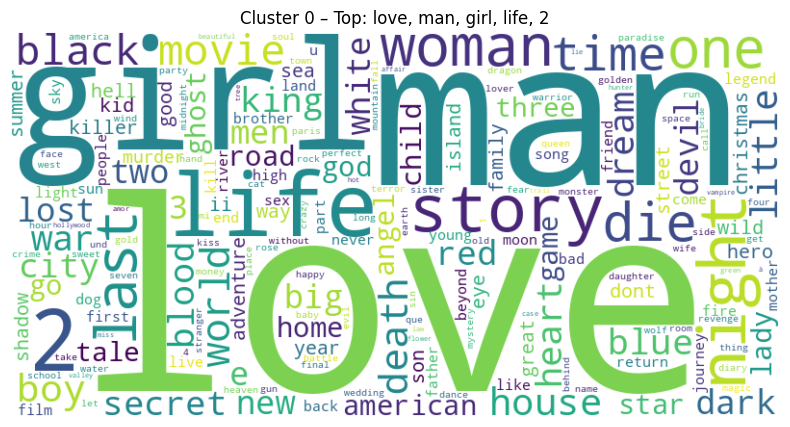

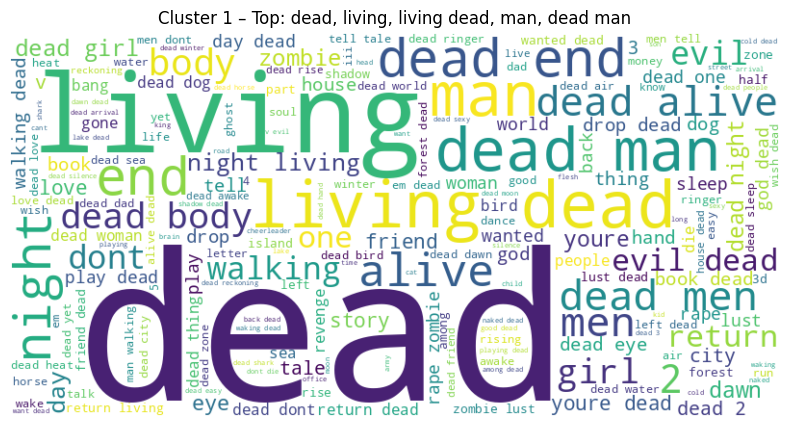

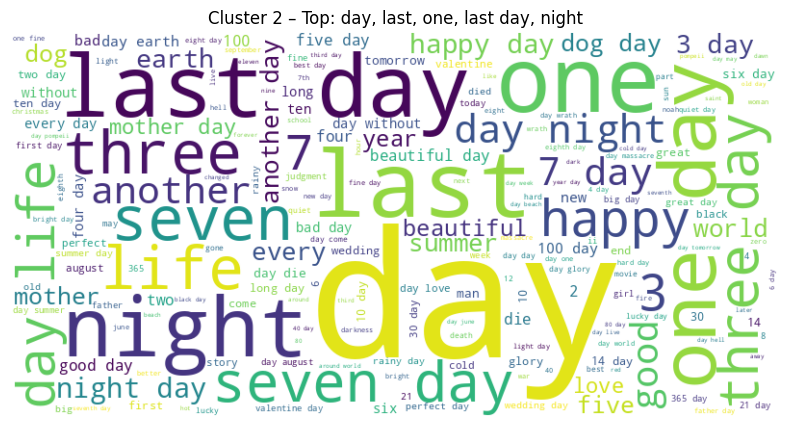

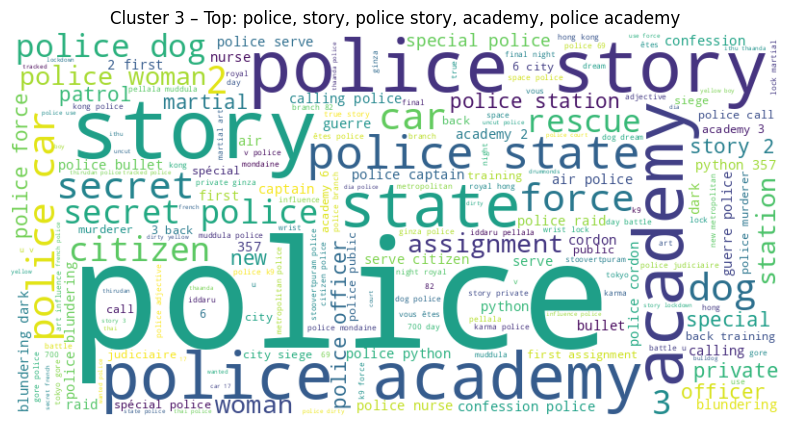

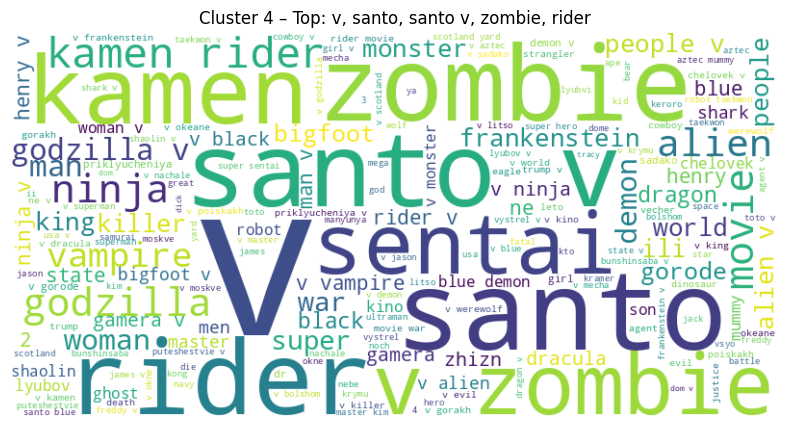

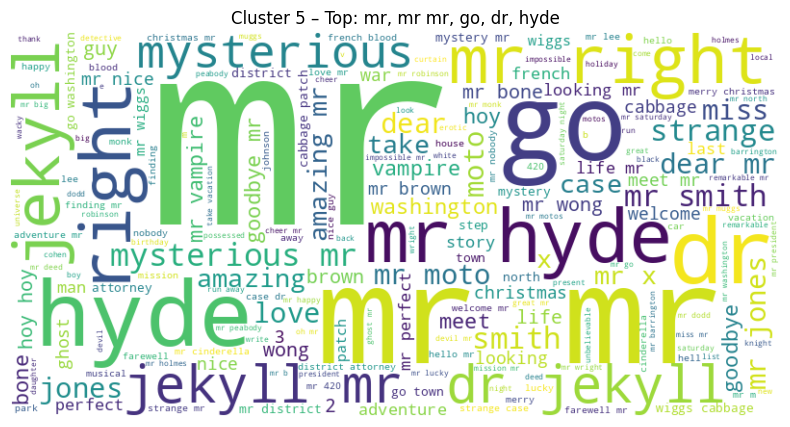

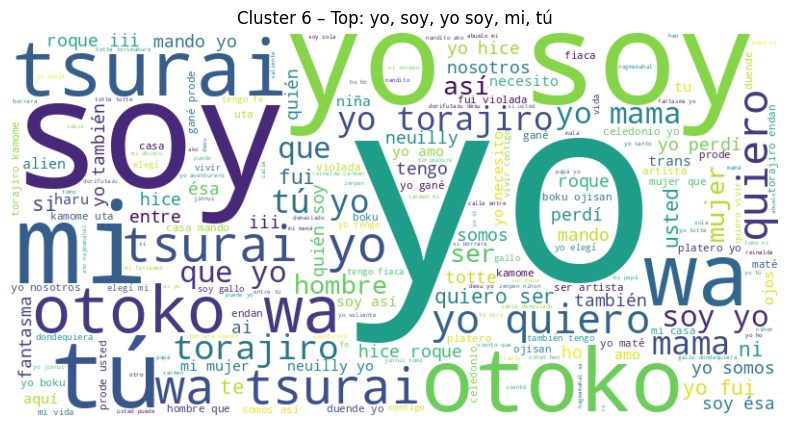

In [68]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cluster_id in sorted(cluster_data["cluster"].unique()):
    tokens = cluster_data[cluster_data["cluster"] == cluster_id]["combined_tokens"].explode()
    freq = Counter(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    top_words = ", ".join([word for word, _ in freq.most_common(5)])
    plt.title(f"Cluster {cluster_id} – Top: {top_words}")
    plt.show()

In [69]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="text_features", predictionCol="cluster", metricName="silhouette",distanceMeasure="squaredEuclidean")
score = evaluator.evaluate(df_kmeans)
print(f"Silhouette Score (with bigrams): {score:.4f}")

Silhouette Score (with bigrams): 0.3242


So we can clearly see an improvment in the Silhouette score, which suggests that the clusters are better separated when we used the bigrams.

**LDA**

In [74]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="lemmatized_tokens", outputCol="features", vocabSize=1000, minDF=5)
cv_model = cv.fit(df_lemm)
df_vectorized = cv_model.transform(df_lemm)

from pyspark.ml.clustering import LDA

lda = LDA(k=7, seed=42, featuresCol="features")  # k = number of topics
lda_model = lda.fit(df_vectorized)

topics = lda_model.describeTopics()
vocab = cv_model.vocabulary

# Map term indices to actual words
topics_words = topics.rdd.map(lambda row: [vocab[i] for i in row['termIndices']]).collect()

for idx, topic in enumerate(topics_words):
    print(f"Topic {idx}: {topic}")

Topic 0: ['movie', 'little', 'war', 'e', 'home', 'white', 'christmas', 'return', 'adventure', 'wild']
Topic 1: ['girl', '2', 'day', 'dead', 'blood', 'king', 'red', 'new', 'road', 'killer']
Topic 2: ['story', 'one', 'heart', 'devil', 'two', 'lady', 'star', 'tale', 'son', 'mother']
Topic 3: ['time', 'death', 'secret', 'men', 'american', '3', 'god', 'song', 'end', 'street']
Topic 4: ['life', 'die', 'blue', 'dark', 'mr', 'ii', 'three', 'sex', 'fire', 'baby']
Topic 5: ['man', 'last', 'woman', 'boy', 'big', 'lost', 'high', 'light', 'friend', 'wife']
Topic 6: ['love', 'night', 'black', 'world', 'house', 'dream', 'city', 'v', 'angel', 'ghost']


The LDA topic detection model successfully uncovered seven distinct themes across the movie dataset. Each topic revealed semantically meaningful clusters of keywords, such as holiday and family-themed terms in Topic 0 (e.g., *home*, *christmas*, *adventure*), horror and thriller elements in Topic 1 (e.g., *dead*, *blood*, *killer*), and romantic or emotional narratives in Topics 2 and 5 (e.g., *heart*, *woman*, *friend*). Additionally, themes of mystery, religion, and the supernatural were evident in other topics. Overall, the model demonstrated a strong ability to group movies by latent thematic structures using only their lemmatized titles.